In [1]:
from mongoDBOperations import MongoDBOps
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Extract data from MongoDB 

In [2]:
mongo_client = MongoDBOps(username="geetharv", pwd='mongo123')
db_name = 'Neemai'
collection_name = 'maternity_wear'
df = mongo_client.get_dataframe_collection(db_name=db_name, collection_name=collection_name)

MongoClient(host=['ac-idejcjz-shard-00-02.qbjonjw.mongodb.net:27017', 'ac-idejcjz-shard-00-01.qbjonjw.mongodb.net:27017', 'ac-idejcjz-shard-00-00.qbjonjw.mongodb.net:27017'], document_class=dict, tz_aware=False, connect=True, retrywrites=True, w='majority', authsource='admin', replicaset='atlas-nxiq8e-shard-0', tls=True)


In [3]:
df.head()

,_id,review_title,ratings,review_comment,size,asin
0,64f5af31e5990a0b0bcc2032,Comfortable,4.0,Good product,3XL,B0BJD8QRCN
1,64f5af31e5990a0b0bcc2033,Style is not good,3.0,Do not like the produdt,L,B0BJD8QRCN
2,64f5af31e5990a0b0bcc2034,Nice and comfy fabric,4.0,Fabric is soft but i think it's little thin so...,XL,B0BJD8QRCN
3,64f5af31e5990a0b0bcc2035,Cloth quality not good,2.0,The material is of low quality and it’s v long...,L,B0BJD8QRCN
4,64f5af31e5990a0b0bcc2036,Excellent,5.0,"Excellent product. Breathable fabric, loved it.",2XL,B0BJD8QRCN


In [4]:
df.shape

(5600, 6)

## Exploratory data analysis

1. Check for duplicate entries and if duplicates exist exclude them.
2. id column and asin column does not provide any additional valuable information. Therefore exclude from the data. 
3. Check 'dress size' distribution 
4. Check 'ratings' distribution

In [5]:
# 1. check for duplicates and exlude them

def exclude_duplicates(df):
    """
    This function identifies duplicate rows in the given dataframe and exludes thm
    
    Parameters:
    - df (Pandas dataframe): the input dataframe
    
    Returns:
    - dataframe with duplicate rows exluded
    
    """
    # Identify duplicates
    dups = df.duplicated()
    
    # Exclude duplicates
    cleaned_df = df[~dups]
    
    return cleaned_df


In [6]:
df = exclude_duplicates(df)

In [7]:
# 2. Exclude id and asin columns
df = df.drop(columns=['_id', 'asin'])
df.head()

,review_title,ratings,review_comment,size
0,Comfortable,4.0,Good product,3XL
1,Style is not good,3.0,Do not like the produdt,L
2,Nice and comfy fabric,4.0,Fabric is soft but i think it's little thin so...,XL
3,Cloth quality not good,2.0,The material is of low quality and it’s v long...,L
4,Excellent,5.0,"Excellent product. Breathable fabric, loved it.",2XL


In [8]:
# 3. Explore dress size distribution

df['size'].value_counts()

size
L          1143
XL         1128
no size    1070
M          1054
2XL         719
S           237
3XL         192
4XL          31
XS           12
Medium       10
XX-L          4
Name: count, dtype: int64

It appears for some entries the size is 'Medium' instead of 'M' and 'XX-L' instead of '2XL'. Replace these values with correct values.

In [9]:
# Replace 'Medium' and 'XX-L' in size column with 'M' and '2XL' respectively. 

values_to_replace = {'Medium':'M', 'XX-L':'2XL'}
df['size'] = df['size'].replace(values_to_replace)
df['size'].value_counts()

size
L          1143
XL         1128
no size    1070
M          1064
2XL         723
S           237
3XL         192
4XL          31
XS           12
Name: count, dtype: int64

In order to plot the sizes in an order XS to 4XL, its better to categorize the 'size' column and also remove 'no size' entries. Some customers have not included the size of the dress they bought in their reviews. For the convenience of visualisation, I excluded those entries where no size was mentioned for generating this plot.

In [10]:
df_size = df[~df['size'].str.contains('no size')]
df_size['size'] = pd.Categorical(df_size['size'], ['XS', 'S', 'M', 'L', 'XL', '2XL', '3XL', '4XL'])


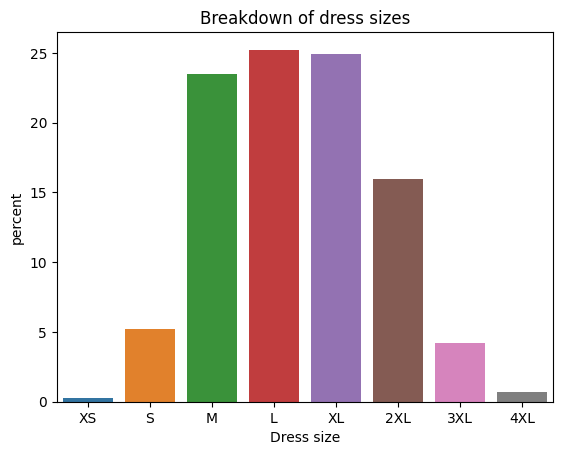

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
# plot breakdown of dress sizes 

ax = sns.countplot(data=df_size, x='size', stat='percent', hue='size', legend=False)
plt.title("Breakdown of dress sizes")
plt.xlabel("Dress size")

plt.show()

It appears that M, L and XL sizes are sold more when compared to other sizes. This observation helps to plan in the production stage. For example, if we consider the ratio XS:S:M:L:XL:2XL:3XL:4XL it would be appropriate to produce 1:5:24:25:25:15:4:1 pieces of the respective sizes. 

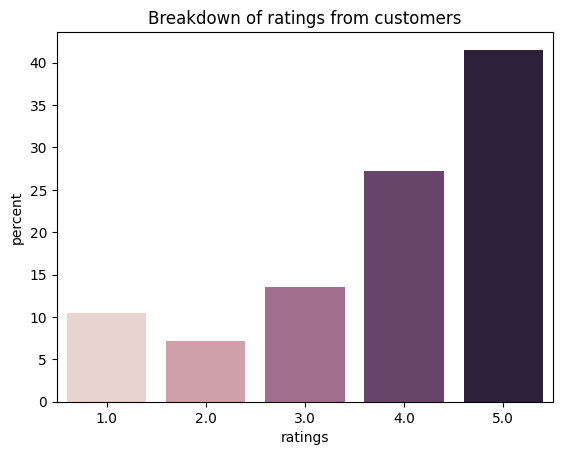

In [12]:
# 4. Explore ratings distribution

ax = sns.countplot(data=df, x='ratings', stat='percent', hue='ratings', legend=False)
plt.title('Breakdown of ratings from customers')
plt.show()

From the above plot, we can see that around 70% of the reviews were positive and approximately 30% were with ratings 3 or below. It would be good to investigate these reviews further in order to obtain deeper insights into the customers views. Particulary to understand what exactly the customers liked and what they disliked. 

To obtain further insights the following steps would be performed:
1. Sentiment analysis 
2. N-grams and word cloud


## Sentiment analysis

In sentiment analysis, there is no need to remove the emojis or emoticons from the text as they
convey the sentiment of the text. Therefore, will not clean them now. 

Here sentiment analysis is performed using **Roberta Pretrained Model** since this model is trained based on a large corpus of data. Additionally, transformer model processes any given word in relation to all other words in a sentence, rather then processing them one at a time i.e., it accounts for context related to other words.

In [13]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from tqdm import tqdm

In [14]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [15]:
def polarity_scores(text):
    
    """
    This function returns polarity scores for the input text
    
    Parameters:
    - text (string): The input text for which the polarity score need to be generated
    
    Returns:
    - dictionary of polarity scores i.e., negative, neutral and positive scores after apply softmax
    
    """
    
    encoded_text = tokenizer(text, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {'neg': scores[0],
                  'neu': scores[1],
                  'pos': scores[2]}
    return scores_dict
    

In [16]:
df = df.reset_index().rename(columns={'index':'Id'})

In [17]:
df.head()

,Id,review_title,ratings,review_comment,size
0,0,Comfortable,4.0,Good product,3XL
1,1,Style is not good,3.0,Do not like the produdt,L
2,2,Nice and comfy fabric,4.0,Fabric is soft but i think it's little thin so...,XL
3,3,Cloth quality not good,2.0,The material is of low quality and it’s v long...,L
4,4,Excellent,5.0,"Excellent product. Breathable fabric, loved it.",2XL


In [19]:
# Get the polarity scores for all the reviews based on review comment and if review comment is not available then 
#Get polarity scores based on review title

result = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        if row['review_comment'] is not None:
            text = row['review_comment'] 
        else:
            text = row['review_title']
            
        row_id = row['Id']
        roberta_results = polarity_scores(text)
        result[row_id] = roberta_results
        
    except ValueError:
        print(f"Broke for id {row_id}")
        
        

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5600/5600 [06:45<00:00, 13.80it/s]


In [20]:
# Convert the result dictionary into dataframe
results_df = pd.DataFrame(result).T
results_df.head()
results_df.shape

(5600, 3)

In [21]:
## Merge the results dataframe and the cleaned_df

results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df)

In [22]:
results_df.head()

,Id,neg,neu,pos,review_title,ratings,review_comment,size
0,0,0.008658,0.099322,0.892019,Comfortable,4.0,Good product,3XL
1,1,0.935027,0.059971,0.005002,Style is not good,3.0,Do not like the produdt,L
2,2,0.020165,0.477054,0.502781,Nice and comfy fabric,4.0,Fabric is soft but i think it's little thin so...,XL
3,3,0.928059,0.064498,0.007443,Cloth quality not good,2.0,The material is of low quality and it’s v long...,L
4,4,0.003775,0.018728,0.977497,Excellent,5.0,"Excellent product. Breathable fabric, loved it.",2XL


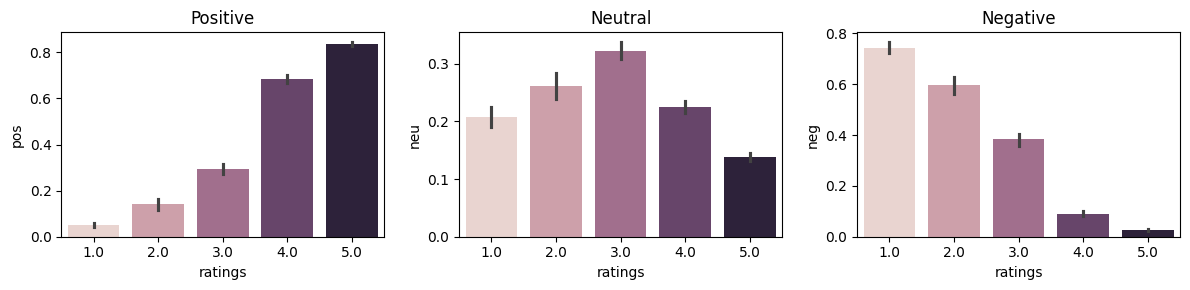

In [23]:
## Plot the polarity scores and the customers ratings

fig, ax = plt.subplots(1,3, figsize=(12,3))
sns.barplot(data=results_df, x='ratings', y='pos', ax=ax[0], hue='ratings', legend=False)
sns.barplot(data=results_df, x='ratings', y='neu', ax=ax[1], hue='ratings', legend=False)
sns.barplot(data=results_df, x='ratings', y='neg', ax=ax[2], hue='ratings', legend=False)
ax[0].set_title('Positive')
ax[1].set_title('Neutral')
ax[2].set_title('Negative')
plt.tight_layout()
plt.show()

Observation: Higher the ratings, higher the positive score and lower the ratings higher the negative score. We also observe some neutral sentiment across all the rating categories.  

In [24]:
# Some examples with highest negative and highest positive scoring

print(f"Positive scoring: {results_df.sort_values('pos', ascending=False)['review_comment'].values[0]}")


Positive scoring: I am really happy to get this product. Very good quality and fit as expected. Thank You Anazon


In [25]:
print(f"Negative scoring: {results_df.sort_values('neg', ascending=False)['review_comment'].values[0]}")

Negative scoring: The product quality is bad, material also uncomfortable, price too highI suggest not to buy this product


## Data cleaning

Before doing further anylsis, it is important to clean the text data in order to make it usable by the different NLP methods. Here starndard preprocessing functions are applied:
- Converting the text to lower case
- Removing punctuations
- Removing numbers
- Removing extra spaces
- Removing emojis and emoticons
- Removing contractions
- Remove stop words

In [27]:
## Function to clean the text data

import string
import contractions
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#nltk.download('stopwords')
#nltk.download('punkt')

def clean_text_df(df, col_name):
    """
    This function cleans the text data i.e., converts the text to lover case, removes punctuations, numbers,
    extra spaces, emojis, emoticons
    
    Parameters:
    - df (DataFrame): The input DataFrame.
    - col_name (str): the name of the column containing the text that has to be cleaned.
    
    Returnes:
    - DataFrame: the DataFrame with cleaned text.
    """
    df[col_name] = df[col_name].apply(lambda x: clean_text(x) if x is not None else None)
    return df
    
    
    
def clean_text(text):
    """
    Convert the input text to lower case, remove contractions, punctuations, numbers, extra spaces, emojis
    and emoticons
    """
    
    # convert text to lower case
    text = text.lower() 
    
    # Remove contractions: There are many words like don't, can't, it's and so on. That would be fixed in this step
    text = contractions.fix(text) 
    
    # Remove punctuations
    text = ''.join(char for char in text if char not in string.punctuation) 
    
    # Remove numbers
    text = ''.join(char for char in text if not char.isdigit()) 
    
    # Remove extra spaces
    text = ' '.join(text.split())
    
    # Remove emojis
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F700-\U0001F77F"  # alchemical symbols
        u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess Symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U00002702-\U000027B0"  # Dingbats
        u"\U000024C2-\U0001F251" 
        "]+"
    )
    
    text = emoji_pattern.sub('', text) 
    
    # Remove emoticons
    
    emoticons = {
    u":‑)": "Happy face or smiley",
    u":)": "Happy face or smiley",
    u":-]": "Happy face or smiley",
    u":]": "Happy face or smiley",
    u":-3": "Happy face smiley",
    u":3": "Happy face smiley",
    u":->": "Happy face smiley",
    u":>": "Happy face smiley",
    u"8-)": "Happy face smiley",
    u":o)": "Happy face smiley",
    u":-}": "Happy face smiley",
    u":}": "Happy face smiley",
    u":-)": "Happy face smiley",
    u":c)": "Happy face smiley",
    u":^)": "Happy face smiley",
    u"=]": "Happy face smiley",
    }

    emoticon_pattern = re.compile("|".join(re.escape(emoticon) for emoticon in emoticons.keys()))
    text = emoticon_pattern.sub('', text) 
    
    # Replace "media could not be loaded with ''"
    text = text.replace('the media could not be loaded', '')

    # Remove stop words
    text = ' '.join(word for word in word_tokenize(text) if word not in stopwords.words('english')) 
    
    return text
    
        
    

In [28]:
cleaned_df = clean_text_df(df, 'review_comment')

## N-grams and word cloud

N-grams are nothing but continuous sequence of words or tokens in a document and the term 'n' refers to the number of items in the sequence. Here, N-grams particulary bigrams and trigrams are used to capture the context of words to determine the customers opinion.  

In [29]:
from nltk import ngrams
from collections import Counter
import wordcloud

# function to generate n-grams

def generate_ngrams(df, col_name, n):
    """
    Create n-grams for a column in a DataFrame
    
    Parameters:
    -df (DataFrame): the input DataFrame
    -col_name (str): the name of the column containing the text data for which n-grams to be generated
    -n (int): the size of the n-grams 
    
    Returns:
    DataFrame : a new dataframe with an additional column containg n-grams
    
    """
    df['ngrams'] = df[col_name].apply(lambda x: list(ngrams(word_tokenize(x),n)) if x is not None else None)
    return df


# function to extract top frequent words
def top_frequent_words(df, col_name, ngrams_num=1, num_top_words=10):
    """
    Create top words for the text
    
    Parameters:
    df (DataFrame): DataFrame containing the text column
    col_name (str): column name that contains the text
    ngrams_num (int): size of n-grams
    num_top_words (int): size of top words 
    
    Returns:
    DataFrame: dataframe with ngrams and their frequencies
    """
    
    frequent=[]
    if ngrams_num==1:
        pass
    
    elif ngrams_num >=2:
        n_grams=df[col_name].apply(lambda x: list(ngrams(word_tokenize(x),ngrams_num)) if x is not None else None)
        list_words = [ngram for i in n_grams if i is not None for ngram in i]
                                   
    else:
        raise ValueError("number of n-grams should be >=1")
    counter = Counter(list_words)
    frequent = counter.most_common(num_top_words)
    return frequent
        
    
        

Using top_frequent_function, the most frequent words, bi-grams or tri-grams can be displayed. Further subsetting the data based on ratings will give us a better perspective of the customers opionions. For example, the bi-grams or tri-grams from the reviews where ratings are 4 and above would give an insight into what customers liked about the product whereas when we consider the ratings below 3 or 2, that would give us an insight about the problems or what customers disliked about the product. 

In [30]:
# Bi-grams and tri-grams for reviews with ratings 4 and above
ratings_4_above_bigrams = pd.DataFrame(top_frequent_words(cleaned_df[cleaned_df['ratings']>=4],'review_comment',2), columns=['bigrams', 'count'])
ratings_4_above_trigrams = pd.DataFrame(top_frequent_words(cleaned_df[cleaned_df['ratings']>=4],'review_comment',3), columns=['trigrams', 'count'])


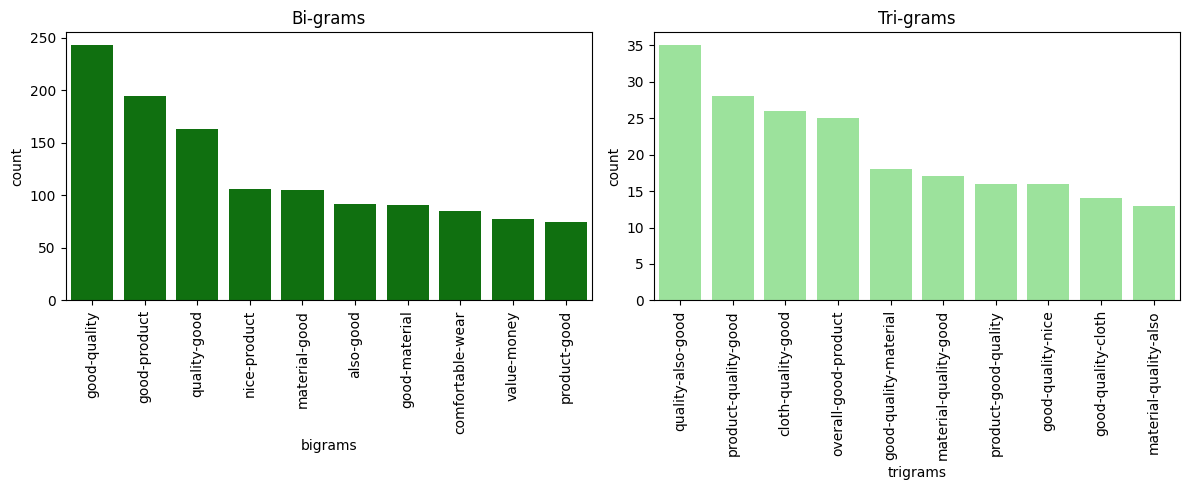

In [31]:
# Plots to display top bi-grams and tri-grams for reviews with ratings >=4
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.barplot(ratings_4_above_bigrams, x=ratings_4_above_bigrams['bigrams'].apply(lambda x: '-'.join(x)), y='count', ax=ax[0], color='green')
sns.barplot(ratings_4_above_trigrams, x=ratings_4_above_trigrams['trigrams'].apply(lambda x: '-'.join(x)), y='count', ax=ax[1], color='lightgreen')
ax[0].set_title('Bi-grams')
ax[1].set_title('Tri-grams')
ax[0].tick_params(axis='x', rotation=90)
ax[1].tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

From the above bi-grams and tri-grams, it can be observed that customers are mainly talking about the quality of the fabric and they imply that the quality of the fabric is good and its comfortable to wear.

Similarly, let us examine the reviews with ratings <=2.

In [32]:
# Bi-grams and tri-grams for the reviews <=2
ratings_3_below_bigrams = pd.DataFrame(top_frequent_words(cleaned_df[cleaned_df['ratings']<=2], 'review_comment', 2), columns=['bigrams', 'count'])
ratings_3_below_trigrams = pd.DataFrame(top_frequent_words(cleaned_df[cleaned_df['ratings']<=2], 'review_comment', 3), columns=['trigrams', 'count'])

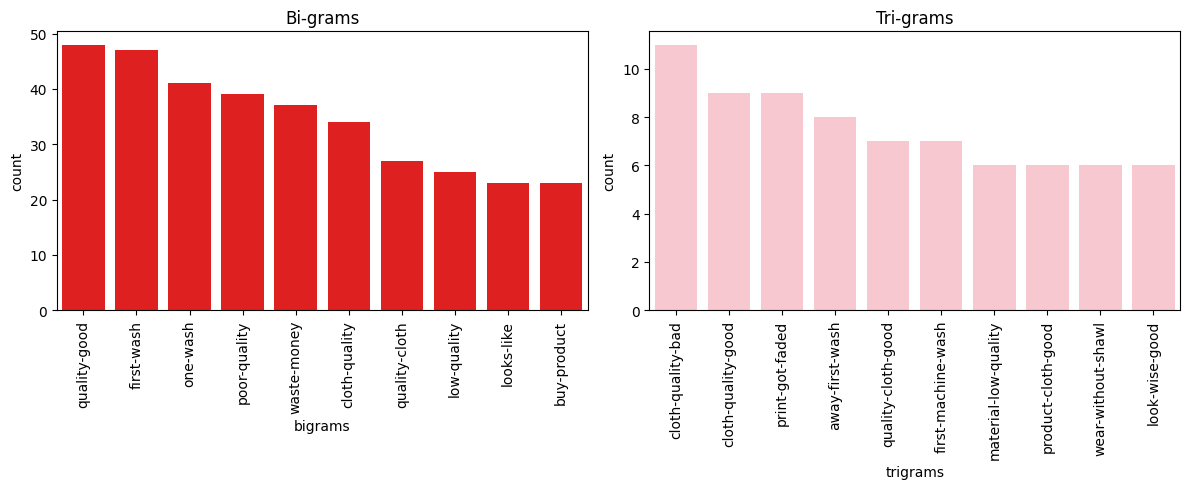

In [33]:
# Plots to display top bi-grams and tri-grams for reviews with ratings <=2
fig, ax = plt.subplots(1,2, figsize=(12, 5))
sns.barplot(ratings_3_below_bigrams, x=ratings_3_below_bigrams['bigrams'].apply(lambda x: '-'.join(x)), y='count', ax=ax[0], color='red')
sns.barplot(ratings_3_below_trigrams, x=ratings_3_below_trigrams['trigrams'].apply(lambda x: '-'.join(x)), y='count', ax=ax[1], color='pink')
ax[0].set_title('Bi-grams')
ax[1].set_title('Tri-grams')
ax[0].tick_params(axis='x', rotation=90)
ax[1].tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()


From the above plots of bi-grams and tri-grams where the ratings were <=2, it can be observed that the customers were not happy about the quality of the fabric. It appears the fabric quality was poor and the color or print faded after first wash or after few washes. 

After examining the top bi-grams and tri-grams from reviews with ratings >=4 and <=2, it can deduced that quality of the fabric is the key feature here. Care should be taken about color bleeding or color fading and the overall quality of the fabric in order to satisfy the customers and to obtain the trust of the consumers.

In [34]:
from wordcloud import WordCloud

## Generate word cloud from reviews with high ratings

def generate_wordcloud(df, col_name):
    """
    Creates word cloud for the text in the given column
    
    Paramters:
    df (DataFrame): dataframe containing the text column
    col_name (str): column name in the dataframe for which word cloud to be generated
    
    Returns:
    word cloud
    """
    #concatenate text
    text = ' '.join([word for row in df[col_name] if row is not None for word in row.split()])
    
    #Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Display the word cloud using Matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

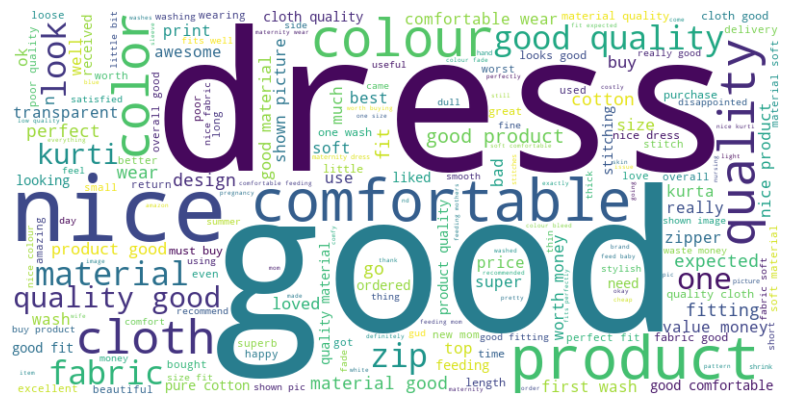

In [35]:
#word cloud with all the reviews
generate_wordcloud(cleaned_df, 'review_comment')

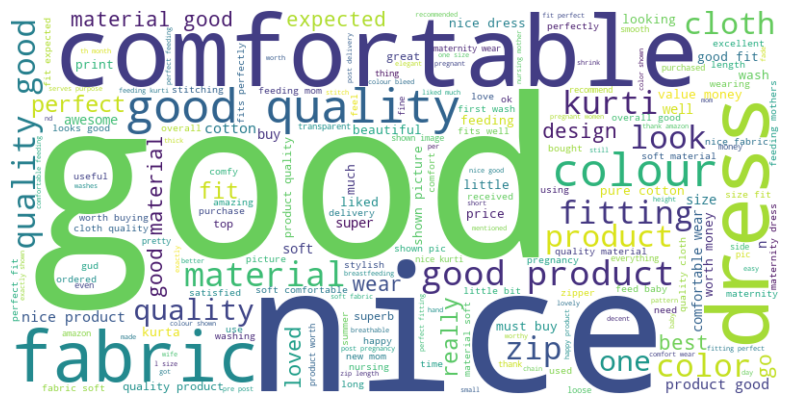

In [36]:
#word cloud with ratings >=4

generate_wordcloud(cleaned_df[cleaned_df['ratings']>=4], 'review_comment')

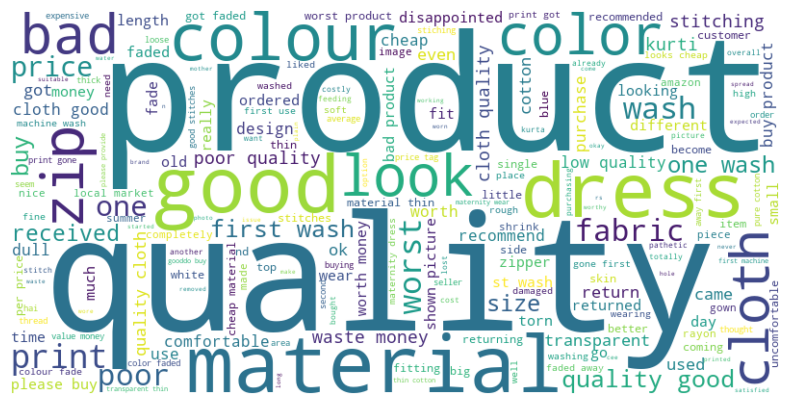

In [40]:
# word cloud with ratings <=2
generate_wordcloud(cleaned_df[cleaned_df['ratings']<=2], 'review_comment')

From the word clouds it is evident that the focus of the reviews is mainly "quality". The reviews with ratings >=4, portray that the product quality is good and comfortable to wear. On the other hand, the reviews with ratings <=2 also portray about quality and it appears the quality is bad and may be there was an issue with zips and colour and print of the fabric. 



## Key points from the data and recommendations to Neemai

The following key points were observed from the data:

1. It appears that M, L and XL sizes are sold more when compared to other sizes. Therefore, in the production stage it would be appropriate to consider the ratio of XS:S:M:L:XL:2XL:3XL:4XL as 1:5:24:25:25:15:4:1 pieces of the respective sizes. 

2. 70% of the ratings were >3 and around 30% were <=3. The sentiment scoring was in par with the ratins i.e., the higher the ratings the higher the positive sentiment and the lower the ratings the higher the negative sentiment.

3. The analysis of reviews with ratings >=4, showed that the customers were happy with the "quality of the fabric".

4. The analyis of reviews with ratings <=2, showed that the customers were not happy with the quality of the fabric. Particualry, the complaints were regarding the color fading/bleeding after first wash or after few washes and also some issues with zips. The key-words: "zip", "bad quality", "print/color" popped up.

**Therefore, the overall recommendation to Neemai is to focus mainly on the quality of the fabric, giving particular attention to zips of the dress and color bleeding or color fading issue of the fabric. These are the major issues observed from the review data.**